# Analysis of Comparison between JHU Source Data vs Latest API vs Archive Differ S3

Check out `jhu_source.py` for the code that creates the json used for this analysis. 

Let's use the term observation to call a one specific combination of: 
- signal (either `confirmed_cumulative_num` or `deaths_cumulative_num`)
- time_value (one day)
- county-level data 
from github jhu source. 

So one observation would consist of a date's data from around 3000 counties, about the cumulative number of either COVID cases or deaths.

Theoretically an observation, its equivalent api call latest result, and the equivalent csv file in the S3 archive differ bucket, all three should all return the same data.


`jhu_source.py` takes an observation data, and compare it to api and S3 equivalent. 

We only care about US county-level data in this comparison.

Before comparison, we remove rows from all 3 places whose values are:
- 0
- NA
- describing megacounties.

Megacounties data are dropped because the source data does not contain them, but the API and S3 dataframes do contain them.
This is why the `jhu_source.py` script should not be used to compare API vs S3 data.

JHU source is from these two files on github:
https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv
https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv


Load the JSON file resulting from the jhu_source.py script run:

In [1]:
import pandas as pd
import json


with open('jhu_source_20241010.json') as f:
    data = json.load(f)
df = pd.json_normalize(data)

In [2]:
df.columns

Index(['date', 'signal', 'skip_reason', 'source_row_count', 'api_row_count',
       's3_row_count', 'source_api_diff_count', 'source_s3_diff_count',
       'api_s3_diff_count'],
      dtype='object')

In [3]:
len(df)

2285

In [4]:
df.head()

,date,signal,skip_reason,source_row_count,api_row_count,s3_row_count,source_api_diff_count,source_s3_diff_count,api_s3_diff_count
0,20200123,confirmed_cumulative_num,File jhu/20200123_county_confirmed_cumulative_...,NaN,NaN,NaN,NaN,NaN,NaN
1,20200124,confirmed_cumulative_num,File jhu/20200124_county_confirmed_cumulative_...,NaN,NaN,NaN,NaN,NaN,NaN
2,20200125,confirmed_cumulative_num,File jhu/20200125_county_confirmed_cumulative_...,NaN,NaN,NaN,NaN,NaN,NaN
3,20200126,confirmed_cumulative_num,File jhu/20200126_county_confirmed_cumulative_...,NaN,NaN,NaN,NaN,NaN,NaN
4,20200127,confirmed_cumulative_num,File jhu/20200127_county_confirmed_cumulative_...,NaN,NaN,NaN,NaN,NaN,NaN


We don't care about the (super early 2020) observasions when there's no api data equivalent. So after removing such data as the below chunk shows, we have 2228 observations for analysis. 

In [5]:
df = df[df['skip_reason'].isna()]
len(df)

2228

Note: In this doc, we care only about the difference between source data vs api and source data vs s3 bucket, NOT api vs s3. Check analysis.ipynb for that.

The below 2 chunks shows every observation has differences with api but is the exact same as what's on the API.

This essentially means the API is wrong and the S3 bucket is right.

In [6]:
len(df[df['source_api_diff_count']!=0]), len(df[df['source_api_diff_count']==0])

(2228, 0)

In [7]:
len(df[df['source_s3_diff_count']!=0]), len(df[df['source_s3_diff_count']==0])

(0, 2228)

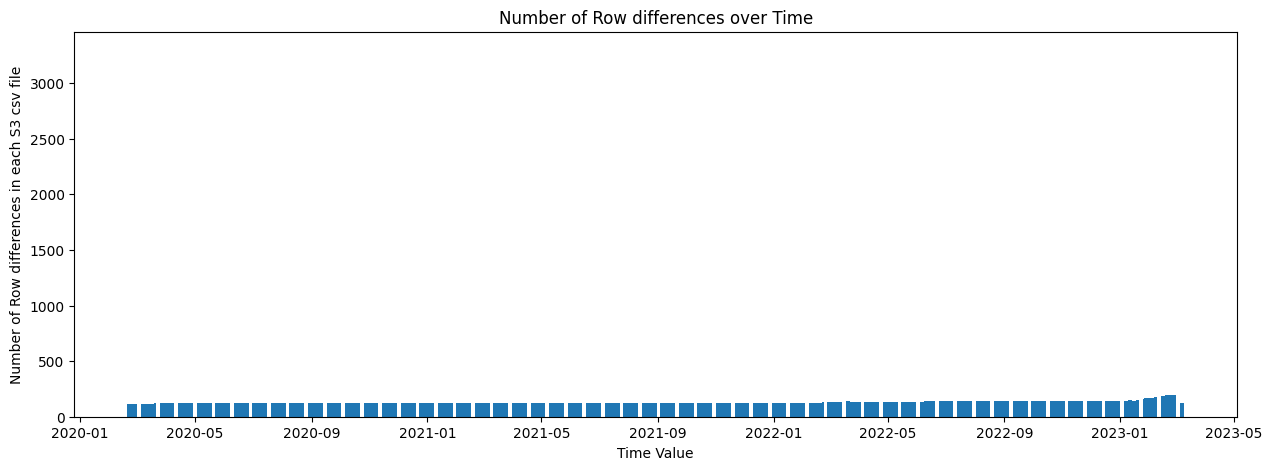

In [8]:
import matplotlib.pyplot as plt


def plot_diff_rows(df):
    jhu_diff = df[df['source_api_diff_count']!=0]
    # Convert 'time_value' to datetime
    jhu_diff['date'] = pd.to_datetime(jhu_diff['date'], format='%Y%m%d')

    # Create a plot
    plt.figure(figsize=(15, 5))
    plt.bar(jhu_diff['date'], jhu_diff['source_api_diff_count'])

    # Set the labels and title
    plt.xlabel('Time Value')
    plt.ylabel('Number of Row differences in each S3 csv file')
    plt.title('Number of Row differences over Time')

    # Display the plot
    plt.show()

plot_diff_rows(df)

In [9]:
df['source_api_diff_count'].max()


3298.0

Let's redo the figure above without these full-file outliers

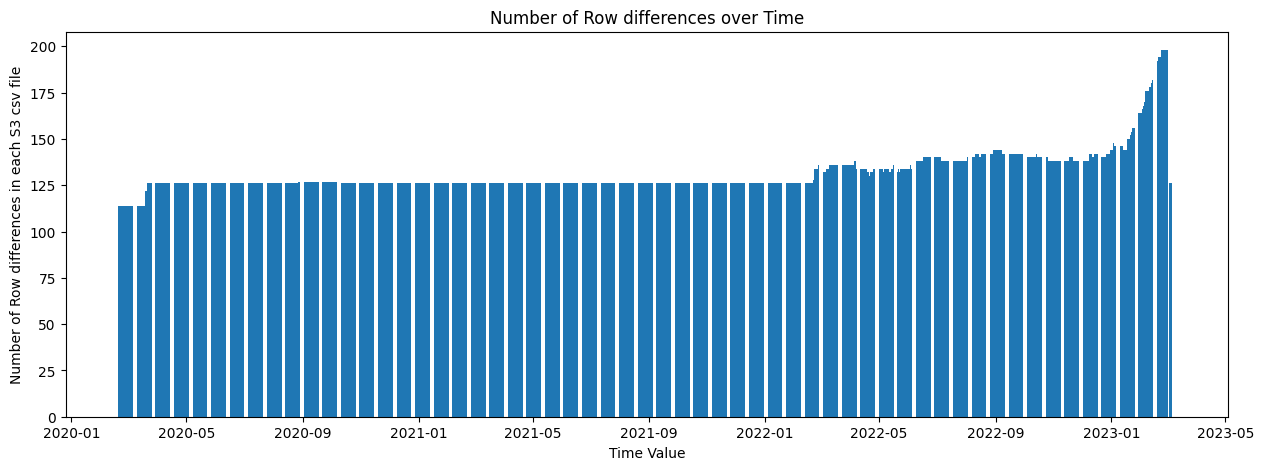

In [10]:
max_index = df['source_api_diff_count'].idxmax()
jhu_diff_no_outlier = df.drop(max_index)
max_index = jhu_diff_no_outlier['source_api_diff_count'].idxmax()
jhu_diff_no_outlier = jhu_diff_no_outlier.drop(max_index)
plot_diff_rows(jhu_diff_no_outlier)